# Is Sympy really 'slow'?
I don't want to be a bad carpenter who blames his tools. Here're my attempts at understanding why my Sympy code is slow. The technical specs of my computer may have a lot to do with the long time things are taking to run, though, any techniques I discover to speed up computation will have a speed up on any system I suppose. 

Ultimately my goal is to have integral and linear algebra routines that can run at sub-second speed, and preferrably a few ms. 

## Potential things to try out 

* ~~I may have been using the wrong Python version of Theano. The [docs](https://theano-pymc.readthedocs.io/en/latest/requirements.html) say official support for Theano is only there for Python <3.6.~~ 
    * ~~install Sympy, Theano nd pyMC3~~ *This doesn't work because Theano didn't seem to recognise 'external' sympy functions, eg. legendre*
    
* With ```lambdify``` use the 'mpmath' module as a backend. This *really* sped up computations, in comparison to the default (sympy?) backend module. 

In [1]:
from joblib import Parallel, delayed
from gmpy2 import *
import matplotlib.pyplot as plt
import mpmath
from mpmath import mpf
dps = 100
mpmath.mp.dps = dps
import numpy as np
from scipy.special import jv as bessel_firstkind
#from symengine import * 
import sympy
from sympy import besselj, symbols, hankel2, legendre, sin, cos, tan, summation, I, oo, diff, pi
from sympy import factor_terms, Matrix
from sympy import Abs, lambdify, integrate, expand,integrate, Integral
from sympy.printing.theanocode import theano_function
from sympy.utilities.autowrap import autowrap
import tqdm
x, alpha, k, m,n, r1, R, theta = symbols('x alpha k m n r1 R theta')
from sympy import N, cse

from sympy.printing.theanocode import theano_function


In [2]:
r1 = (R*cos(alpha))/cos(theta)
Lm_expr = expand(legendre(m, cos(theta))*(r1**2/R**2)*tan(theta))# 
Lm_wo_leg = (r1**2/R**2)*tan(theta)

In [3]:
Lm_expr


cos(alpha)**2*tan(theta)*legendre(m, cos(theta))/cos(theta)**2

In [4]:
substitute_dict = {'alpha':sympy.Rational(np.radians(10)), 'k':5,'R':sympy.Rational(0.1), 'm':20,'n':10}

In [5]:
Lm = Integral(Lm_expr, (theta,0,alpha))#.doit(meijerg=True)
Lm

Integral(cos(alpha)**2*tan(theta)*legendre(m, cos(theta))/cos(theta)**2, (theta, 0, alpha))

In [6]:
%%time
Lm.subs(substitute_dict)

CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 10.3 ms


Integral((34461632205*cos(theta)**20/262144 - 83945001525*cos(theta)**18/131072 + 347123925225*cos(theta)**16/262144 - 49589132175*cos(theta)**14/32768 + 136745788725*cos(theta)**12/131072 - 29113619535*cos(theta)**10/65536 + 15058768725*cos(theta)**8/131072 - 557732175*cos(theta)**6/32768 + 334639305*cos(theta)**4/262144 - 4849845*cos(theta)**2/131072 + 46189/262144)*cos(6288211335136391/36028797018963968)**2*tan(theta)/cos(theta)**2, (theta, 0, 6288211335136391/36028797018963968))

In [7]:
# eqn 12.107
Kmn_expr = expand(legendre(n, cos(theta))*legendre(m, cos(theta))*sin(theta) )
Kmn = Integral(Kmn_expr, (theta, alpha, pi)).doit(meijerg=True)
Kmn

Integral(sin(theta)*legendre(m, cos(theta))*legendre(n, cos(theta)), (theta, alpha, pi))

In [8]:
%%time
Kmn.subs(substitute_dict)

CPU times: user 8.48 ms, sys: 97 µs, total: 8.58 ms
Wall time: 8.55 ms


Integral((46189*cos(theta)**10/256 - 109395*cos(theta)**8/256 + 45045*cos(theta)**6/128 - 15015*cos(theta)**4/128 + 3465*cos(theta)**2/256 - 63/256)*(34461632205*cos(theta)**20/262144 - 83945001525*cos(theta)**18/131072 + 347123925225*cos(theta)**16/262144 - 49589132175*cos(theta)**14/32768 + 136745788725*cos(theta)**12/131072 - 29113619535*cos(theta)**10/65536 + 15058768725*cos(theta)**8/131072 - 557732175*cos(theta)**6/32768 + 334639305*cos(theta)**4/262144 - 4849845*cos(theta)**2/131072 + 46189/262144)*sin(theta), (theta, 6288211335136391/36028797018963968, pi))

In [9]:
%%time
N(Kmn.subs(substitute_dict),dps)

CPU times: user 8.07 s, sys: 20.6 ms, total: 8.09 s
Wall time: 8.09 s


-0.001727547462648632651566050875068465751494226171518181482997361897449925444398259724115500946819197209

In [10]:
Kmn

Integral(sin(theta)*legendre(m, cos(theta))*legendre(n, cos(theta)), (theta, alpha, pi))

In [11]:
kmn_lambdify = lambdify([m,n,alpha],Kmn,'mpmath')

In [12]:
np.radians(10)

0.17453292519943295

In [13]:
substitute_dict

{'alpha': 6288211335136391/36028797018963968,
 'k': 5,
 'R': 3602879701896397/36028797018963968,
 'm': 20,
 'n': 10}

In [14]:
%%time
kmn_lambdify(substitute_dict['m'],
             substitute_dict['n'],
             substitute_dict['alpha'])

CPU times: user 303 ms, sys: 4.19 ms, total: 307 ms
Wall time: 307 ms


mpf('-0.001727547462648632651566050875068465751494226171518181482997361897449925444398259724115500946819197208954')

In [15]:
Imn_part1 = (n*hankel2(n-1,k*r1)-(n+1)*hankel2(n+1,k*r1))*legendre(n, cos(theta))*cos(theta)
Imn_part2 = n*(n+1)*hankel2(n, k*r1)*(legendre(n-1, cos(theta)-legendre(n+1, cos(theta))))/k*r1
Imn_parts = expand(Imn_part1+Imn_part2)
Imn_expr = expand(Imn_parts*legendre(m,cos(theta))*(r1**2/R**2)*tan(theta))
Imn = Integral(Imn_expr, (theta, 0, alpha)).doit(meijerg=True)

Imn_lambdify = lambdify([m,n,k,R,alpha], Imn,'mpmath')

In [16]:
Imn

-(Integral(k*tan(theta)*hankel2(n + 1, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n, cos(theta))/cos(theta), (theta, 0, alpha)) + Integral(-k*n*tan(theta)*hankel2(n - 1, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n, cos(theta))/cos(theta), (theta, 0, alpha)) + Integral(k*n*tan(theta)*hankel2(n + 1, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n, cos(theta))/cos(theta), (theta, 0, alpha)) + Integral(-R*n*cos(alpha)*tan(theta)*hankel2(n, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n - 1, cos(theta) - legendre(n + 1, cos(theta)))/cos(theta)**3, (theta, 0, alpha)) + Integral(-R*n**2*cos(alpha)*tan(theta)*hankel2(n, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n - 1, cos(theta) - legendre(n + 1, cos(theta)))/cos(theta)**3, (theta, 0, alpha)))*cos(alpha)**2/k

In [17]:
M_mn = (Imn + (n*hankel2(n-1,k*R) - (n+1)*hankel2(n+1,k*R) )*Kmn)/(2*n+1).doit(meijerg=True)
M_mn_func = lambdify((m,n,k,R,alpha), M_mn,'mpmath')


In [18]:
b = -I*Lm
b_func = lambdify([m,alpha], b,'mpmath')

In [19]:
Lm

Integral(cos(alpha)**2*tan(theta)*legendre(m, cos(theta))/cos(theta)**2, (theta, 0, alpha))

In [20]:
%%time
b_func(substitute_dict['m'],
       substitute_dict['alpha'])

CPU times: user 108 ms, sys: 199 µs, total: 108 ms
Wall time: 107 ms


mpc(real='0.0', imag='-0.0008098262850926050777410678902535758222607521355914125525164515166435803306093484471288396559860545548289')

In [21]:
Nv = 10
M_matrix = mpmath.matrix(Nv,Nv)
b_matrix = mpmath.matrix(Nv,1)


In [22]:

frequency = 50*10**3 # kHz
vsound = 330 # m/s
wavelength = vsound/frequency
alpha_value = mpf(np.radians(60))
k_value = mpf(2*np.pi/(wavelength))
ka = 5
a_value = ka/k_value 
R_value = a_value/mpmath.sin(alpha_value) # m


In [23]:
params = {'k':k_value, 'a':a_value, 'R':R_value, 'alpha':alpha_value}

In [24]:
rowcol = [ ]
for eachn in range(Nv):
    for eachm in range(Nv):
        rowcol.append((eachm,eachn))

#M_values = Parallel(n_jobs=4)( delayed(M_mn_func)(pos[0], pos[1], k_value, R_value, alpha_value)  for pos in tqdm.tqdm(rowcol))
M_values = [M_mn_func(pos[0], pos[1], params['k'], params['R'], params['alpha'])  for pos in tqdm.tqdm(rowcol)]


100%|██████████| 100/100 [18:38<00:00, 11.19s/it]


In [25]:
for each_m in range(Nv):
    #M_matrix[each_m, each_n] = M_mn_func(each_m, each_n, k_value, R_value, alpha_value)
    b_matrix[each_m,:] = b_func(each_m, alpha_value)
for i,pos in enumerate(rowcol):
    M_matrix[pos[0],pos[1]] = M_values[i]

In [26]:
a_matrix = mpmath.lu_solve(M_matrix,b_matrix)

In [27]:
a_matrix.rows

10

In [28]:
legendre_func = lambdify((m, x), legendre(m, x),'mpmath')
def d_theta(angle,k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    legendre_matrix = np.array([legendre_func(n_v, np.cos(angle)) for n_v in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix, legendre_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1]*X[2], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def d_zero(k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def relative_directionality_db(angle,k_v,R_v,alpha_v,An):
    off_axis = d_theta(angle,k_v,R_v,alpha_v,An)
    on_axis = d_zero(k_v,R_v,alpha_v,An)
    rel_level = 20*mpmath.log10(abs(off_axis/on_axis))
    return rel_level

In [29]:

angles = np.linspace(0,2*np.pi,200)
dirnlty = [relative_directionality_db(angle_v, k_value, R_value,alpha_value,a_matrix) for angle_v in angles]


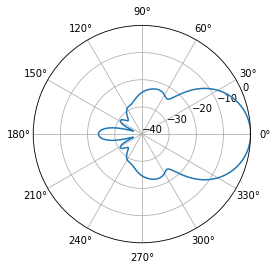

In [36]:
plt.figure()
a0 = plt.subplot(111, projection='polar')
plt.plot(angles, dirnlty)
plt.ylim(-40,0);plt.yticks([0,-10,-20,-30,-40]);
plt.xticks(np.radians(np.arange(0,360,30)));